# Signature Classification

![img](https://github.com/ZachRauch/Signature_Classification/blob/main/images/signature_banner.jpeg?raw=1)

## Overview

The aim of this analysis is to identify fraudulent signatures in a dataset. My audience here is Wells Fargo's Fraud and Financial Crimes Department. Using just a small dataset with only 300 sample I was able to create a classification model to predict whether a signature is genuine or forged. 

## Business Problem

Currently institutions and businesses recognize signatures as the primary way of authenticating transactions. Signatures are used to sign checks, authorize documents and contracts, and validate credit card transactions. According to recent studies, check fraud costs banks about $900M a year with 22 percent of all fraudulent checks attributed to signature fraud. Therefor, creating an algorithm to identify signature fraud or flagging suspicious signatures for further investigation is a valuable asset. 

## Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import zipfile

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, metrics, regularizers, losses
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import auc, recall_score, precision_score, \
                            confusion_matrix, plot_confusion_matrix, \
                            roc_auc_score, roc_curve
import pickle

seed = 777
tf.random.set_seed(seed)
np.random.seed(seed)

The function below will plot the fit results of each model to help determine which model to use.

In [5]:
def plot_results(results):
  train_loss = results.history['loss']
  train_acc = results.history['accuracy']
  val_loss = results.history['val_loss']
  val_acc = results.history['val_accuracy']

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
  sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

  sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
  sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
  ax1.set_title('Loss')
  ax2.set_title('Accuracy')
  ax1.legend();
  return 

The function below returns the maximum validation accuracy of a model's fit and it's associated validation loss score. This is necessary because the weights of a model are saved at the highest validation accuracy score.

In [67]:
def validation_results(results):
  val_acc = max(results.history['val_accuracy'])
  val_loss = results.history['val_loss'][results.history['val_accuracy'].index(val_acc)]
  return print(f'Maximum Validation Accuracy: {val_acc}. Loss at Max Validation Accuracy: {val_loss}')



## Colab Necessary Code

Google Colab was used to help streamline the modeling process. Modeling using Convolutional Neural Networks can be computationally expensive, so to run this notebook faster I created a Colab account and stored the data and my models in a Google Drive file. The code below allows Google Colab to connect to your Google Drive files.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

The data used in this notebook can be found [here](https://www.kaggle.com/datasets/divyanshrai/handwritten-signatures). The dataset contains just 300 samples of genuine and forged signatures from 30 people, of which 50 percent are genuine and 50 percent are forged. 

In [8]:
# instantiate ImageDataGenerator scaling each pixel's values down to a scale of 1
img = ImageDataGenerator(rescale=1/255)

In [9]:
# For locally run notebooks
# data_path = './Data/sample_Signature/sample_Signature/'
# For Colab 
data_path = '/content/drive/MyDrive/sample_Signature/sample_Signature/'

In [10]:
# Importing the data
data = img.flow_from_directory(data_path, color_mode='grayscale',\
                               batch_size=300, class_mode='binary')

Found 300 images belonging to 2 classes.


In [11]:
data.class_indices

{'forged': 0, 'genuine': 1}

In [12]:
data_images, data_labels = next(data)

In [13]:
data_images.shape

(300, 256, 256, 1)

In [14]:
data_labels.shape

(300,)

In [15]:
X_train, X_test, y_train, y_test = train_test_split( \
            data_images, data_labels, random_state=seed, test_size=.2)

In [16]:
X_train.shape

(240, 256, 256, 1)

In [17]:
y_train.shape

(240,)

Above we instantiate Keras' ImageDataGenerator which will scale each pixel's values down to a value from 0 to 1. Next we import the data and separate into images themselves and their respective classes or labels, to be used as our target variable. Finally we split it into a train and test dataset. We are left with an array for the images where the first number indicates the number of data points or images. The next two numbers are the shape of each image in pixels. and the final number is the number of channels. Channels indicate the colors, however in this case we are using 'grayscale' for black and white so we have a single channel. For our labels, we have an array with just each label that corresponds to each image.

### Image Augmentation

Because we have such a small dataset it is important to use image augmentation to artificially expand the training dataset. Below we do several forms of data augmentation individually before combining each techniques at the end.

#### Zoom Augmentation

The first technique we explore is zoom range. Entering a range of values, .25 and 1 in this case, randomly applies a zoom to each image within that range.

In [18]:
aug = ImageDataGenerator(zoom_range=[.25,1])
aug.fit(X_train)
aug_data = aug.flow(X_train, y_train, batch_size=240)

In [19]:
aug_images, aug_labels = next(aug_data)

In [20]:
aug_images.shape

(240, 256, 256, 1)

In [21]:
aug_labels.shape

(240,)

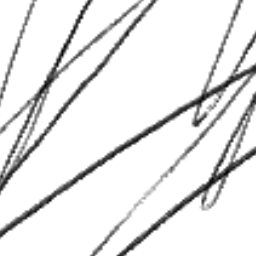

In [22]:
array_to_img(aug_images[0])

In [23]:
new_images1 = np.concatenate([X_train, aug_images])
new_labels1 = np.concatenate([y_train, aug_labels])

In [24]:
new_images1.shape

(480, 256, 256, 1)

In [25]:
new_labels1.shape

(480,)

#### Width Augmentation

The next method for augmentation used was width shift range. With a range of .3 the images will be randomly assigned a width down to .3 of the original image size. 

In [26]:
aug = ImageDataGenerator(width_shift_range=.3)
aug.fit(X_train)
aug2_data = aug.flow(X_train, y_train, batch_size=240)

In [27]:
aug2_images, aug2_labels = next(aug2_data)

In [28]:
new_images2 = np.concatenate([new_images1, aug2_images])
new_labels2 = np.concatenate([new_labels1, aug2_labels])

#### Height Augmentation

The next method for augmentation used was height shift range. With a range of .3 the images will be randomly assigned a height down to .3 of the original image size.

In [29]:
aug = ImageDataGenerator(height_shift_range=.3)
aug.fit(X_train)
aug3_data = aug.flow(X_train, y_train, batch_size=240)

In [30]:
aug3_images, aug3_labels = next(aug3_data)

In [31]:
new_images3 = np.concatenate([new_images2, aug3_images])
new_labels3 = np.concatenate([new_labels2, aug3_labels])

#### Rotation Augmentation

Next we apply a random rotation to each image up to 30 degrees.

In [32]:
aug = ImageDataGenerator(rotation_range=30)
aug.fit(X_train)
aug4_data = aug.flow(X_train, y_train, batch_size=240)

In [33]:
aug4_images, aug4_labels = next(aug4_data)

In [34]:
new_images4 = np.concatenate([new_images3, aug4_images])
new_labels4 = np.concatenate([new_labels3, aug4_labels])

#### Shear Augmentation

We then apply a random shear value to each image. This angles the corners of each image up to 30 degrees.

In [35]:
aug = ImageDataGenerator(shear_range=30)
aug.fit(X_train)
aug5_data = aug.flow(X_train, y_train, batch_size=240)

In [36]:
aug5_images, aug5_labels = next(aug5_data)

In [37]:
new_images5 = np.concatenate([new_images4, aug5_images])
new_labels5 = np.concatenate([new_labels4, aug5_labels])

#### Brightness Augmentation

Finally we have brightness augmentation. This applies a random brightness shift within the provided range. 

In [38]:
aug = ImageDataGenerator(brightness_range=(1,2))
aug.fit(X_train)
aug5_data = aug.flow(X_train, y_train, batch_size=240)

In [39]:
aug6_images, aug6_labels = next(aug5_data)

In [40]:
new_images6 = np.concatenate([new_images5, aug6_images])
new_labels6 = np.concatenate([new_labels5, aug6_labels])

In [41]:
new_labels6.shape

(1680,)

#### A little bit of everything Augmentation

Now that we have augmented each image with a single augmentation, we will again augment all images with a combination of each augmentation. In the end we are left with 3360 images.

In [42]:
aug = ImageDataGenerator(zoom_range=[.7,.9], width_shift_range=.15, height_shift_range=.15, rotation_range=15, shear_range=15, brightness_range=(1,1.5))
aug.fit(new_images6)
aug_data_final = aug.flow(new_images6, new_labels6, batch_size=1680)

In [43]:
aug_final_images, aug_final_labels = next(aug_data_final)

In [44]:
final_images = np.concatenate([new_images6, aug_final_images])
final_labels = np.concatenate([new_labels6, aug_final_labels])

In [45]:
final_images.shape

(3360, 256, 256, 1)

In [46]:
final_labels.shape

(3360,)

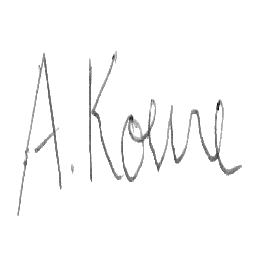

In [47]:
array_to_img(final_images[0])

In [48]:
final_labels[0]

0.0

## Modeling

I used a Keras wrapper in order to utilize scikit learns cross validation to assist in evaluating each model. I also used metrics of validation loss and validation accuracy in determining the final model by fitting each model with a validation split of 20%. I will only provide a few models here but there are more models in the [Workspace](https://github.com/ZachRauch/Signature_Classification/tree/main/Workspace) folder.

### Dummy Model

Our first model will be a baseline model for comparison. We will utilize Sklearn's DummyClassifier which uses the most frequent class as it's prediction. 

In [49]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(final_images, final_labels)

DummyClassifier(strategy='most_frequent')

In [50]:
dummy_acc = dummy_model.score(X_test, y_test)

In [51]:
dummy_acc

0.45

Our goal for each model is to beat this baseline score.

### Model 1

Model1 uses Adam as its optimizer with a lowered the learning rate. It has two 2D convolutional layers, a dense layer with a 25 percent dropout rate, a dense layer with L2 or Ridge regularization, and a dense layer with both a dropout and L2 regularization. Regularization and dropout were utilized to combat overfitting as CNN networks are prone to do. The architecture is provided but the crossvalidation and fit for the model were run in it's respective notebook in the [Workspace](https://github.com/ZachRauch/Signature_Classification/tree/main/Workspace) folder. Model1 was fit over 20 epochs with batch sizes of 32. In addition a ModelCheckpoint was used to save the weghts of the best Epoch in regards to validation accuracy.

In [52]:
adam = Adam(lr=.0001)
def build_model():
    model1 = Sequential()
    model1.add(layers.Conv2D(filters=64,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(256,256,1)))

    model1.add(layers.MaxPool2D())

    model1.add(layers.Conv2D(128, (3,3), activation='relu'))

    model1.add(layers.MaxPool2D())
    
    model1.add(layers.Flatten())
    model1.add(layers.Dense(64, activation='relu'))
    model1.add(layers.Dropout(.25))

    model1.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(0.05)))

    model1.add(layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model1.add(layers.Dropout(.25))
    
    model1.add(layers.Dense(1, activation='sigmoid'))

    model1.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [53]:
model1 = scikit_learn.KerasClassifier(build_model,
                                          epochs=20, 
                                          batch_size=32, 
                                          verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


In [54]:
model1_filepath = '/content/drive/MyDrive/model1_checkpoint'
model1_checkpoint_callback = ModelCheckpoint(filepath=model1_filepath,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max')

In [55]:
with open('drive/MyDrive/model1_cv_pickle.sav', 'rb') as f:
    model1_cv_results = pickle.load(f)

In [56]:
model1_cv = model1_cv_results.mean()
model1_cv

0.5895833373069763

In [57]:
with open('drive/MyDrive/model1_results_pickle.sav', 'rb') as f:
    model1_results = pickle.load(f)

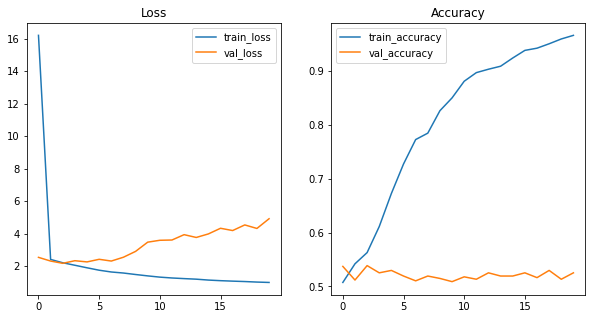

In [58]:
plot_results(model1_results)

In [68]:
validation_results(model1_results)

Maximum Validation Accuracy: 0.538690447807312. Loss at Max Validation Accuracy: 2.1739375591278076


Overall Model1 had a crossvalidation score of 59%. However, when fit, the maximum validation accuracy was 54% and the loss at this point was over 2. 

### Model 2

In [69]:
sgd = SGD(lr=.0001)
def build_model():
    model = Sequential()
    model.add(layers.Conv2D(filters=64,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(256,256,1)))

    model.add(layers.MaxPool2D())
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(.05))
    
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(.25))

    model.add(layers.Dense(16, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=sgd,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [70]:
model2 = scikit_learn.KerasClassifier(build_model,
                                          epochs=10,
                                          batch_size=24,
                                          verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


In [71]:
model2_filepath = '/content/drive/MyDrive/model2_checkpoint'
model2_checkpoint_callback = ModelCheckpoint(filepath=model2_filepath,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max')

In [72]:
with open('drive/MyDrive/model2_cv_pickle.sav', 'rb') as f:
    model2_cv_results = pickle.load(f)

In [73]:
model2_cv = model2_cv_results.mean()
model2_cv

0.5773809552192688

In [74]:
with open('drive/MyDrive/model2_results_pickle.sav', 'rb') as f:
    model2_results = pickle.load(f)

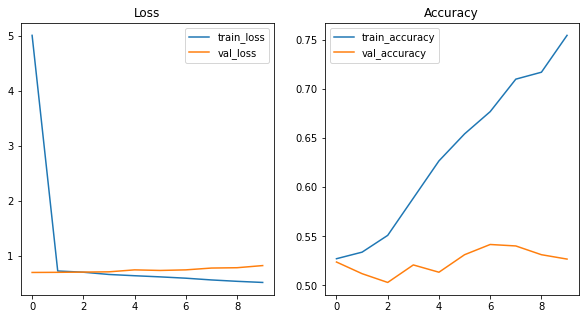

In [75]:
plot_results(model2_results)

In [77]:
validation_results(model2_results)

Maximum Validation Accuracy: 0.5416666865348816. Loss at Max Validation Accuracy: 0.7453436851501465


Overall Model2 had a crossvalidation score of 58%. The maximum validation accuracy was 54% and the loss at this point was just .75. This is an improvement over Model1.

### Model 3

In [78]:
adam = Adam(learning_rate=.0001)
def build_model():
    model = Sequential()

    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(256,256,1)))
    model.add(layers.MaxPool2D())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.MaxPool2D())

    model.add(layers.Flatten())

    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(32, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [79]:
model3 = scikit_learn.KerasClassifier(build_model,
                                          epochs=25,
                                          batch_size=32,
                                          verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


In [80]:
model3_filepath = '/content/drive/MyDrive/model3_checkpoint'
model3_checkpoint_callback = ModelCheckpoint(filepath=model3_filepath,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max')

In [81]:
with open('drive/MyDrive/model3_cv_pickle.sav', 'rb') as f:
    model3_cv_results = pickle.load(f)

In [82]:
model3_cv = model3_cv_results.mean()
model3_cv

0.5497023820877075

In [83]:
with open('drive/MyDrive/model3_results_pickle.sav', 'rb') as f:
    model3_results = pickle.load(f)

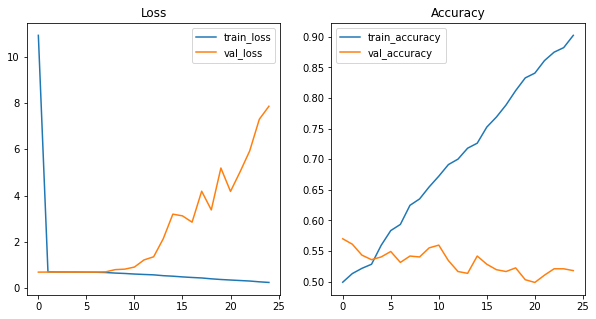

In [84]:
plot_results(model3_results)

In [85]:
validation_results(model3_results)

Maximum Validation Accuracy: 0.569940447807312. Loss at Max Validation Accuracy: 0.6886444091796875


Model3's crossvalidation score was 55%. When fit the model's maximum validation accuracy was 57% with a loss of .69. This is the highest fitted validation accuracy and lowest loss score yet, however, the crossvalidation score could be higher.

### Model 4

In [86]:
adam = Adam(learning_rate=.0001)
def build_model():
    model = Sequential()

    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(256,256,1)))
    model.add(layers.MaxPool2D())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(32, (7,7), activation='relu'))
    model.add(layers.MaxPool2D())

    model.add(layers.Conv2D(64, (5,5), activation='relu'))
    model.add(layers.MaxPool2D())

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(.05)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(.1)))

    model.add(layers.Dense(32, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [87]:
model4 = scikit_learn.KerasClassifier(build_model,
                                          epochs=50,
                                          batch_size=32,
                                          verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


In [88]:
model4_filepath = '/content/drive/MyDrive/model4_checkpoint'
model4_checkpoint_callback = ModelCheckpoint(filepath=model4_filepath,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max')

In [89]:
with open('drive/MyDrive/model4_cv_pickle.sav', 'rb') as f:
    model4_cv_results = pickle.load(f)

In [90]:
model4_cv = model4_cv_results.mean()
model4_cv

0.5889880895614624

In [91]:
with open('drive/MyDrive/model4_results_pickle.sav', 'rb') as f:
    model4_results = pickle.load(f)

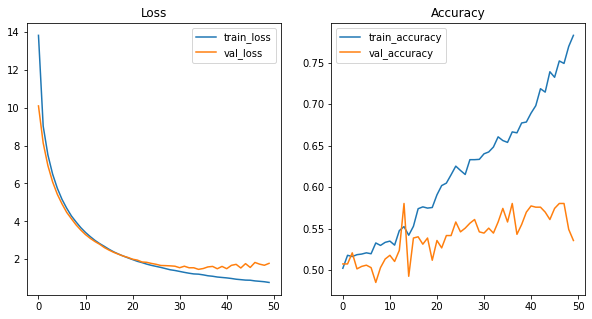

In [92]:
plot_results(model4_results)

In [93]:
validation_results(model4_results)

Maximum Validation Accuracy: 0.5803571343421936. Loss at Max Validation Accuracy: 2.7924892902374268


Model4 crossvalidation score is 59% with a fitted validation accuracy of 58%. However, the loss score here would be 2.8 which is quite high. 

### Model 5 VGG16

VGG16 is an example of a pre-trained model for image classification. It's results are promising after just one epoch, however, it requires the data to be in a specific format which in turn takes up more system memory. Currently, my resources are limited in regards to memory so I am unable to fully train and implament this model. With additional resources it is likely that this or other pretrained models will perform better. 

In [94]:
# vgg16 = VGG16(input_shape=(224,224, 3), classes=1, include_top=False, classifier_activation='sigmoid')
# model5 = Sequential()
# model5.add(vgg16)
# model5.add(layers.Flatten())
# model5.add(layers.Dense(1, activation='sigmoid'))
# adam = Adam(learning_rate=.0001)
# model5.compile(optimizer=adam,
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

In [95]:
with open('drive/MyDrive/model5_results_pickle.sav', 'rb') as f:
    model5_results = pickle.load(f)

In [96]:
accuracy = model5_results.history['accuracy']
validation_accuracy = model5_results.history['val_accuracy']

loss = model5_results.history['loss']
validation_loss =  model5_results.history['val_loss']

In [97]:
print(f'Accuracy: {accuracy[0]}')
print(f'Validation Accuracy: {validation_accuracy[0]}')
print(f'Loss: {loss[0]}')
print(f'Validation Loss: {validation_loss[0]}')

Accuracy: 0.5107886791229248
Validation Accuracy: 0.555059552192688
Loss: 0.7597837448120117
Validation Loss: 0.6887924075126648


In [98]:
# with open('drive/MyDrive/model5_pickle.sav', 'rb') as f:
#     model5 = pickle.load(f)

### Model 7

In [99]:
adam = Adam(learning_rate=.0001)
def build_model():
    model = Sequential()

    model.add(layers.Conv2D(128, (7,7), activation='relu', input_shape=(256,256,1)))
    model.add(layers.MaxPool2D())

    model.add(layers.Conv2D(64, (5,5), activation='relu'))
    model.add(layers.MaxPool2D())

    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPool2D())

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(.05)))
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(.05)))

    model.add(layers.Dense(32, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [100]:
model7 = scikit_learn.KerasClassifier(build_model,
                                          epochs=30,
                                          batch_size=40,
                                          verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


In [101]:
model7_filepath = '/content/drive/MyDrive/model7_checkpoint'
model7_checkpoint_callback = ModelCheckpoint(filepath=model7_filepath,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max')

In [102]:
with open('drive/MyDrive/model7_cv_pickle.sav', 'rb') as f:
    model7_cv_results = pickle.load(f)

In [103]:
model7_cv = model7_cv_results.mean()
model7_cv

0.549404776096344

In [104]:
with open('drive/MyDrive/model7_results_pickle.sav', 'rb') as f:
    model7_results = pickle.load(f)

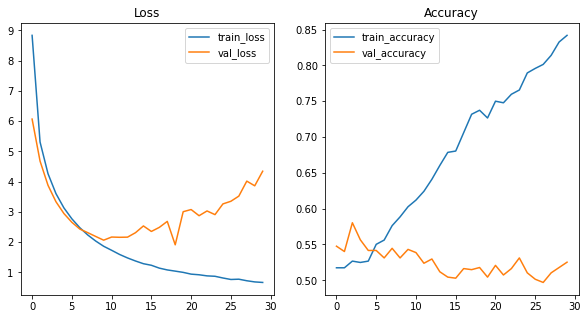

In [105]:
plot_results(model7_results)

In [106]:
validation_results(model7_results)

Maximum Validation Accuracy: 0.5803571343421936. Loss at Max Validation Accuracy: 3.880034923553467


Model7 crossvalidation score is 55% with a fitted validation accuracy of 58%. However, the loss score here would be 3.9 which is quite high.

## Final Model Evaluation

For the final model I chose Model3. Model3 had some of the best validation accuracies while maintaining a low loss. 

In [107]:
with open('drive/MyDrive/model3_pickle.sav', 'rb') as f:
    final_model = pickle.load(f)

In [108]:
final_model.score(X_test, y_test)

2/2 - 11s - loss: 0.6802 - accuracy: 0.6667 - 11s/epoch - 6s/step


0.6666666865348816

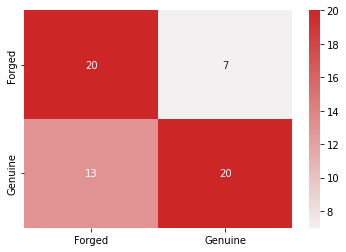

In [112]:
color = sns.color_palette("light:#CD2626", as_cmap=True)
preds = final_model.predict(X_test)
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, cmap=color, 
            xticklabels= ['Forged', 'Genuine'],
            yticklabels= ['Forged', 'Genuine'])
plt.savefig('/content/drive/MyDrive/confusion_matrix.png')
plt.savefig('/content/drive/MyDrive/confusion_matrix.jpeg');

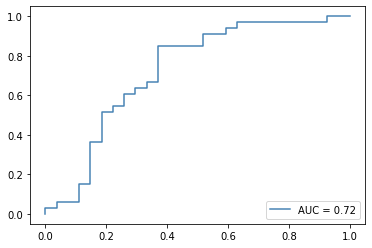

In [113]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = final_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = round((roc_auc_score(y_test, lr_probs)), 2)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, label=f'AUC = {lr_auc}', color='steelblue') 
# show the legend
plt.legend(loc='lower right');
plt.savefig('/content/drive/MyDrive/auc_curve.png')
plt.savefig('/content/drive/MyDrive/auc_curve.jpeg');

## Next Steps and Limitations

- In this case my access to data was limited and and a bit resrepresentative of real data. First off, I started with just 300 images. Ideally, I would have more data to train my models on increasing their accuracies. Next the classes of genuine and forged signatures were balanced which is unlikely to happen in the real world. It is likely that a collection of forged signatures may be hard to come by and therefor be underrepresented in actual data. This may make recognising patterns within the forged signatures more difficult. Finally, there are different forms of forgery that are likely absent from this dataset. Forgeries may be random/blind, untrained, or skilled forgeries. It is unclear which of these this dataset includes. 
- Another hinderance to this project was resources. More memory, computing power and time would prove quite benificial in producing better models. More memory would allow me to run more tests, create more eleborate models and utilize more data. More computing power would save time and also allow for more complex models. More time would allow me to further my research, apply it, and again run more complex models. 

## Conclusion

I created a model that accurately classifies signatures correctly 67 percent of the time. With more data, time, and resources this accuracy may increase substantially. 

## App

To demonstrate this model's usitility I have developed an app that uses the model developed in this notebook to classify any uploaded images. 

In [ ]:
!pip install streamlit
!pip install pyngrok

In [1]:
import streamlit as st
from pyngrok import ngrok

2022-05-31 23:48:22.053 INFO    numexpr.utils: NumExpr defaulting to 2 threads.


In [ ]:
!streamlit run /content/drive/MyDrive/app.py & npx localtunnel --port 8501

2022-05-31 19:33:06.280 INFO    numexpr.utils: NumExpr defaulting to 2 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.233.218.135:8501

npx: installed 22 in 2.325s
your url is: https://rotten-rooms-worry-35-233-218-135.loca.lt
2022-05-31 19:33:27.676714: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
  Stopping...
^C
